In [1]:
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb, rgb2gray
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from skimage.segmentation import mark_boundaries
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import glob
import keras
from keras import layers
from keras.layers import Dense
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
import cv2
from cv2 import imread, createCLAHE
import glob
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output
from keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from tqdm import tqdm
from keras.losses import Loss
from keras.callbacks import TensorBoard
from scipy.ndimage import distance_transform_edt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.applications import VGG19
from keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

2023-10-18 23:08:56.881572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 23:08:57.073339: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-18 23:08:57.998077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-18 23:08:57.998285: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Training_Input/*.png')
mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1_Training_GroundTruth/*.png')


In [3]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [4]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (128, 128))

                mask = cv2.imread(mask_path,0)
                mask = cv2.resize(mask, (128, 128))


                # normalize the image and mask to have values between 0 and 1
                img = img / 255.0
                mask= mask/ 255.0


                batch_images.append(img)
                batch_masks.append(mask)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)


            yield batch_images, batch_masks
# #
generator = data_generator(image_paths, mask_paths, 1)

for _,imgpath in tqdm(enumerate(image_paths)):
   batch = next(generator)


0it [00:00, ?it/s]

Number of images: 2594
Number of masks: 2594


2594it [15:48,  2.73it/s]


In [5]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

In [6]:
def precision(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_flat, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

In [7]:
def sensitivity(gt_mask, pred_mask):

    gt_mask_flat = K.flatten(gt_mask)
    pred_mask_flat = K.flatten(pred_mask)

    # compute true positive (TP) and false negative (FN) counts
    TP = K.sum(gt_mask_flat * pred_mask_flat)
    FN = K.sum(gt_mask_flat * (1 - pred_mask_flat))

    # compute sensitivity (recall)
    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # print(y_true.shape)
    # print(y_pred.shape)
    intersection = K.sum(y_true_f * y_pred_f)
    # print(y_pred)
    # print(y_true)
    # print(np.amax(y_pred))
    # print(np.amax(y_true))
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [9]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred,1)

In [10]:
assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=2023
)
# Define the batch size
batch_size = 8

# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)


# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)

259
64


In [11]:
def build_unet(input_size=(256,256,3)):

    inputs  = Input(input_size)

    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool5)
    conv6 = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)


    up7 = layers.concatenate([Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(conv6), conv5], axis=3)


    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)


    up8 = layers.concatenate([Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv7), conv4], axis=3)

    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv8), conv3], axis=3)

    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = layers.concatenate([Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv9), conv2], axis=3)

    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up11 = layers.concatenate([Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv10), conv1], axis=3)

    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(1, (1,1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])


In [12]:
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'


In [13]:

weight_path="{}_full_pixel_skin_Dunet.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2023-10-18 23:30:30.401652: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-10-18 23:30:30.401712: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-10-18 23:30:30.473089: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-10-18 23:30:30.474501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-10-18 23:30:30.508781: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-10-18 23:30:30.509032: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [14]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    # outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs2)
    return model

In [15]:
model = build_model(shape=(128, 128, 3 ))

opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss= dice_coef_loss,metrics= [dice_coef, precision, iou, sensitivity] ,run_eagerly=True)
model.summary()

2023-10-18 23:30:42.042759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 23:30:42.143796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 23:30:42.144066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 23:30:42.146270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [16]:
loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)

# model.save("full_pixel.h5")
model.save("full_pixel_Dunet_skin.h5")

/tmp/ipykernel_164705/1996138446.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(


Number of images: 2075
Number of masks: 2075
Epoch 1/50


2023-10-18 23:30:56.678415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2023-10-18 23:30:57.798737: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-18 23:30:57.800934: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-18 23:30:57.800967: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-10-18 23:30:57.801099: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

2023-10-18 23:31:03.456490: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-18 23:31:03.802614: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-18 23:31:03.912727: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

  1/259 [..............................] - ETA: 1:49:01 - loss: 0.7840 - dice_coef: 0.2160 - precision: 0.1254 - iou: 0.1211 - sensitivity: 0.5291

2023-10-18 23:31:20.529213: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-10-18 23:31:20.529243: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


  2/259 [..............................] - ETA: 5:07 - loss: 0.7015 - dice_coef: 0.2985 - precision: 0.2159 - iou: 0.1782 - sensitivity: 0.5317   

2023-10-18 23:31:21.575886: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-10-18 23:31:21.609364: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-10-18 23:31:21.683261: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 2796 callback api events and 2885 activity events. 
2023-10-18 23:31:21.705460: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-10-18 23:31:21.709065: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2023_10_18_23_31_21/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


259/259 [==============================] - ETA: 0s - loss: 0.4678 - dice_coef: 0.5322 - precision: 0.6238 - iou: 0.3711 - sensitivity: 0.8734Number of images: 519
Number of masks: 519

Epoch 1: val_loss improved from inf to 0.47153, saving model to cxr_reg_full_pixel_skin_Dunet.best.hdf5
259/259 [==============================] - 926s 3s/step - loss: 0.4678 - dice_coef: 0.5322 - precision: 0.6238 - iou: 0.3711 - sensitivity: 0.8734 - val_loss: 0.4715 - val_dice_coef: 0.5285 - val_precision: 0.6687 - val_iou: 0.3640 - val_sensitivity: 0.8154 - lr: 1.0000e-04
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.3763 - dice_coef: 0.6228 - precision: 0.7436 - iou: 0.4613 - sensitivity: 0.9236
Epoch 2: val_loss improved from 0.47153 to 0.41533, saving model to cxr_reg_full_pixel_skin_Dunet.best.hdf5
259/259 [==============================] - 857s 3s/step - loss: 0.3763 - dice_coef: 0.6228 - precision: 0.7436 - iou: 0.4613 - sensitivity: 0.9236 - val_loss: 0.4153 - val_dic

In [20]:
test_images = []
ground_truth_test_images = []

# # define the paths to the images and their ground truths
test_paths = glob.glob('/home/somayeh/PycharmProjects/pythonProject2/ISBI2016_ISIC_Part1_Test_Data/*.png')
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/pythonProject2/ISBI2016_ISIC_Part1_Test_GroundTruth/*.png")



(379, 128, 128, 3)
(379, 128, 128)
379/379 [==============================] - 45s 116ms/step
(379, 128, 128, 1)
(379, 128, 128, 1)
(379, 128, 128)
Dices: [<tf.Tensor: shape=(), dtype=float64, numpy=0.9401699203584428>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9571493468836901>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8940329183946555>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9503174076889487>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9494383390122914>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9492236566542975>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7129303893773936>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9610988693019944>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9600624685910537>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9311053500700179>, <tf.Tensor: shape=(), dtype=float64, numpy=0.964675434140407>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9570923401715159>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9143697101240398>, <tf.Tensor: sh

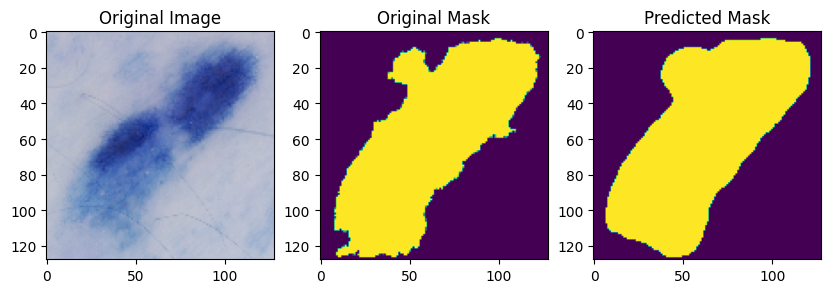

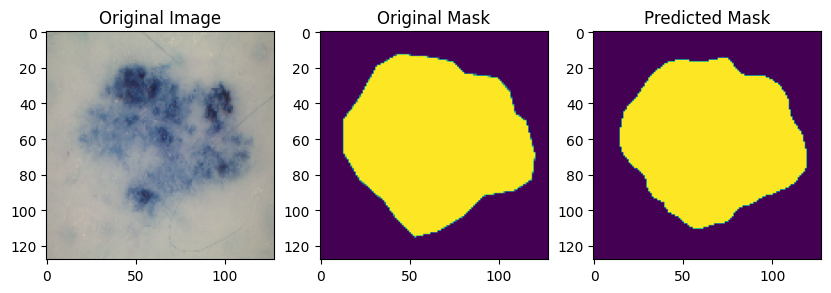

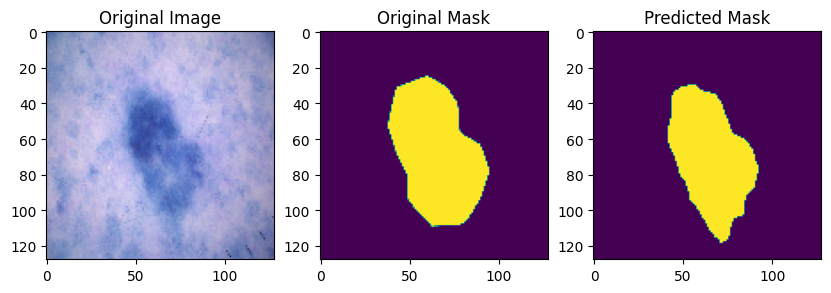

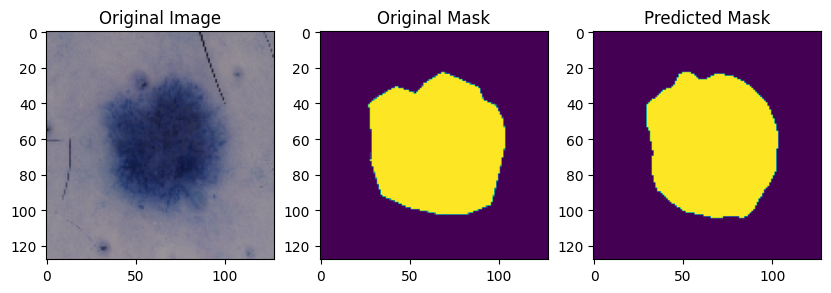

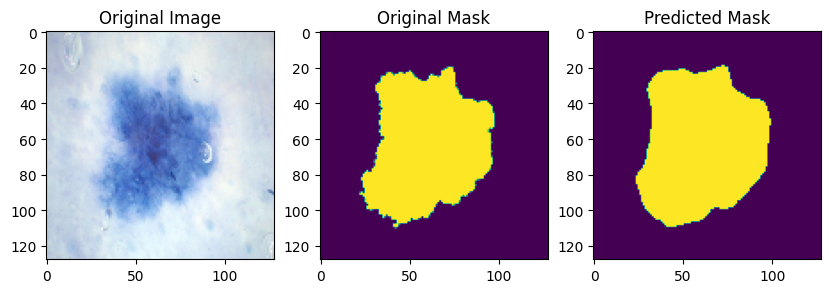

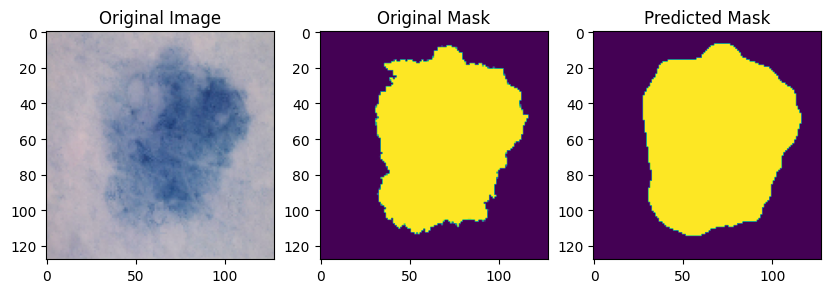

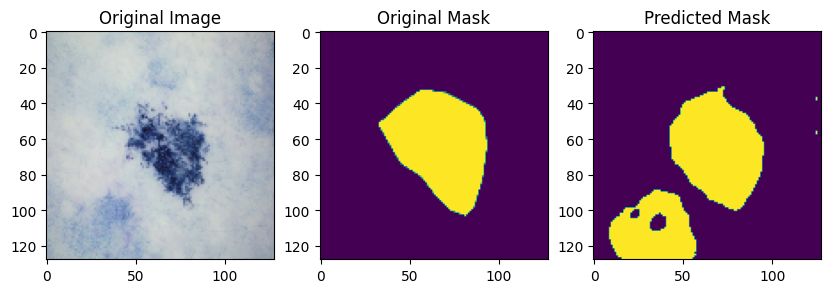

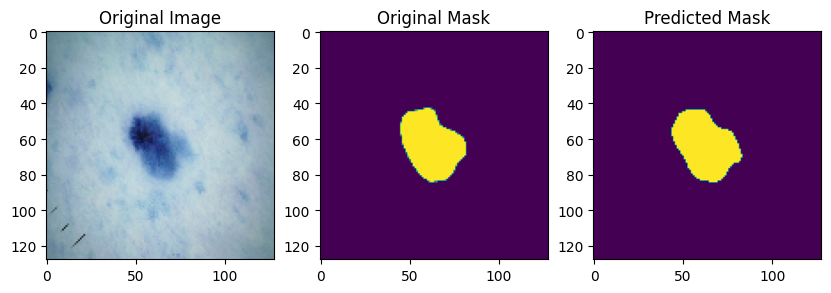

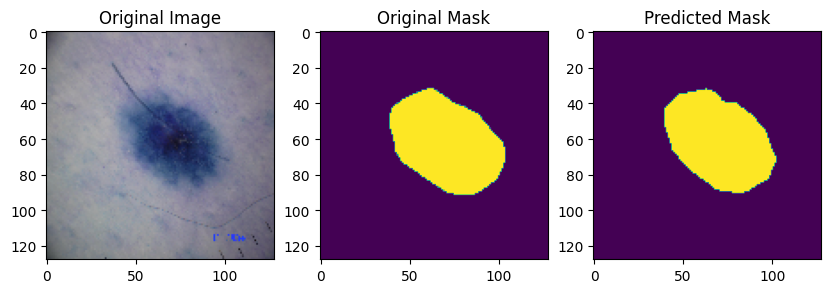

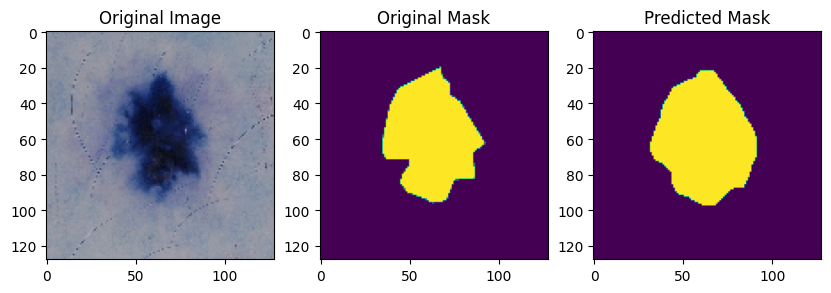

In [21]:
dice_scores = []
for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (128, 128))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (128, 128))

# normalize the image and mask to have values between 0 and 1

    test_image = test_image / 255.0
    ground_truth_test_image= ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)


#by the end of this line, I have superpixeled images.
# convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)
print(test_images.shape)
print(ground_truth_test_images.shape)
# add a channel dimension to the masks
# ground_truth_test_images = np.expand_dims(ground_truth_test_images, axis=-1)

# model.load_weights("{}_soft_label.best.hdf5".format('cxr_reg'))
# model.load_weights("{}_doubel_Unet_soft_label.best.hdf5".format('cxr_reg'))
model.load_weights("{}_full_pixel_skin_Dunet.best.hdf5".format('cxr_reg'))

# Make predictions
# predicted_masks = model.predict(test_images)
tf.config.run_functions_eagerly(True)
predicted_masks = model.predict(
    test_images,
    batch_size=1,
    verbose=1,
    steps=None,
    callbacks=None
)

predicted_mask_array = np.array(predicted_masks)
print(predicted_mask_array.shape)

# Convert the NumPy array to uint8 format
predicted_mask_array = (predicted_mask_array * 255).astype(np.uint8)
print(predicted_mask_array.shape)

#
dst = np.empty([predicted_mask_array.shape[0],predicted_mask_array.shape[1],predicted_mask_array.shape[2]])
kernel = np.ones((5,5),np.float64)/25
# dst = predicted_mask_array

#
for i in range(predicted_mask_array.shape[0]):

        threshold_value = 1
        _, dst[i] = cv2.threshold(predicted_mask_array[i], threshold_value, 255, cv2.THRESH_BINARY)
        dst[i] = np.array(dst[i])
        dst[i] = tf.convert_to_tensor(dst[i] / 255.0,dtype=predicted_masks.dtype)

print(dst.shape)

## Cast the input tensor to a double tensor
ground_truth_test_images = tf.cast(ground_truth_test_images, dtype=tf.float64)
predicted_masks = tf.cast(dst, dtype=tf.float64)
# predicted_masks = tf.cast(predicted_mask_array, dtype=tf.float64)
# Apply thresholding

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    dice = dice_coef(y_true, y_pred)

    y_pred = predicted_masks[i]

    precision_value = precision(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

# dice_score = dice_coef(ground_truth_test_images, dst)
# precision_val = precision(ground_truth_test_images, dst)
# sensitivity_val = sensitivity(ground_truth_test_images, dst)
# iou_val = iou(ground_truth_test_images, dst)
# print(type(dst))

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)

n =10 # number of images to show
for i in range(n):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i])
    ax[1].set_title('Original Mask')
    ax[2].imshow(dst[i])
    ax[2].set_title('Predicted Mask')
    plt.show()